# library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers,Input
from keras.models import  Sequential,load_model
from keras.optimizers import SGD
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint
from keras.regularizers import L1L2
import keras.backend as K
import hls4ml

2023-07-31 18:14:42.569119: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 18:14:42.692183: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-31 18:14:42.720569: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-31 18:14:43.170984: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [3]:
xTrain=np.load("../Data/julyData/trainData.npy")
yTrain=np.load("../Data/julyData/trainTarget.npy")
xTest=np.load('../Data/julyData/testData.npy')
yTest=np.load("../Data/julyData/testTarget.npy")

X_train=np.reshape(xTrain,(xTrain.shape[0],20,100))
X_test=np.reshape(xTest,(xTest.shape[0],20,100))

xTrain_r=np.reshape(xTrain,(xTrain.shape[0],xTrain.shape[1]))
yTrain=np.reshape(yTrain,(yTrain.shape[0]))
xTest_r=np.reshape(xTest,(xTest.shape[0],xTest.shape[1]))
yTest=np.reshape(yTest,(yTest.shape[0]))



print(xTrain.shape)

(1600, 2000)


# PCA

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc = StandardScaler()
X_train = sc.fit_transform(xTrain_r)
X_test = sc.transform(xTest_r)
pca = PCA(n_components = 100)
X_train = pca.fit_transform(X_train)
print (pca.explained_variance_)
print (pca.explained_variance_ratio_)
print (pca.explained_variance_ratio_.cumsum())
X_test = pca.transform(X_test)
print("X shape: {}".format(X_train.shape))
del xTest,xTrain,xTest_r,xTrain_r

[7.37314513 7.26858534 6.27678229 5.14826494 4.95262119 4.8444645
 4.75130361 4.68458792 4.61031313 4.58430339 4.55782553 4.54001239
 4.50234835 4.48828114 4.42802519 4.41803633 4.39750343 4.37832726
 4.35236683 4.34490985 4.30726738 4.27218349 4.26925878 4.25913927
 4.23343171 4.21829447 4.20959671 4.20823033 4.18231654 4.16091432
 4.14612117 4.13240374 4.12055162 4.11816321 4.11055576 4.09350266
 4.08515321 4.06852059 4.04185867 4.03600707 4.02226238 3.98570262
 3.97898116 3.97095478 3.95014959 3.93359959 3.93095068 3.92719986
 3.91112038 3.89741348 3.88378391 3.87126103 3.85236418 3.84463824
 3.82931067 3.82161276 3.79946108 3.79086359 3.77808843 3.76439314
 3.75628178 3.74143344 3.73046817 3.71326198 3.70695289 3.7021813
 3.6904227  3.68561329 3.6633561  3.65153596 3.62176593 3.61476363
 3.6071491  3.59576933 3.58563109 3.57460738 3.5580075  3.53806119
 3.53423157 3.51805909 3.51011668 3.50201002 3.49864692 3.48815357
 3.46867816 3.44627638 3.44102582 3.43040969 3.41684364 3.410379

In [5]:
X_train=np.reshape(X_train,(X_train.shape[0],10,10))
yTrain=np.reshape(yTrain,(yTrain.shape[0]))
X_test=np.reshape(X_test,(X_test.shape[0],10,10))
yTest=np.reshape(yTest,(yTest.shape[0]))
print(X_train.shape, yTrain.shape)

(1600, 10, 10) (1600,)


In [6]:
def arch():
    model=Sequential()
    model.add(Input(shape=(10,10)))
    # model.add(layers.CuDNNLSTM(units=256, return_sequences=True,kernel_regularizer=L1L2(0.0001)))
    model.add(layers.LSTM(units=64, return_sequences=True, kernel_regularizer=L1L2(0.00001)))
    model.add(layers.LSTM(units=64, return_sequences=False,kernel_regularizer=L1L2(0.00001)))
    model.add(layers.Dense(64,activation='selu'))
    model.add(layers.Dropout(0.6))
    model.add(layers.Dense(32,activation='selu'))
    model.add(layers.Dropout(0.6))
    model.add(layers.Dense(16,activation='selu'))
    model.add(layers.Dropout(0.6))
    model.add(layers.Dense(4,activation='selu'))
    model.add(layers.Dropout(0.6))
    model.add(layers.Dense(1,activation='sigmoid'))
    return model


def arch2():
    model=Sequential()
    model.add(Input(shape=(None,100)))
    model.add(layers.CuDNNLSTM(units=256,return_sequences=True,kernel_regularizer=L1L2(0.000001)))
    model.add(layers.CuDNNLSTM(units=128,return_sequences=False,kernel_regularizer=L1L2(0.000001)))
    model.add(layers.Dense(128,activation='selu'))
    model.add(layers.Dense(64,activation='selu'))
    model.add(layers.Dense(32,activation='selu'))
    model.add(layers.Dense(16,activation='selu'))
    model.add(layers.Dense(8,activation='selu'))
    model.add(layers.Dense(1,activation='sigmoid'))
    return model
# arch2().summary()

In [7]:
# Loss
def loss(y_true, y_pred):

    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

    # Calculate the binary cross entropy
    bce =  -((y_true * K.log(y_pred)) + (1 - y_true) * K.log(1 - y_pred))
    
    mean_bce = K.mean(bce, axis=-1)

    return mean_bce
    
def f1_score(y_true, y_pred):
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
    # clip predictions to avoid 0/0 division
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # calculate true positives, false positives, and false negatives
    tp = K.sum(K.round(y_true * y_pred))
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
    # calculate precision and recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    # calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1_score

In [17]:
model=arch()
model.summary()
opt=SGD( learning_rate=0.001, momentum=0.9)
model.compile(loss=binary_crossentropy, optimizer='adam', metrics=['accuracy'])
model_path="../Model/RNN_new/{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            19200     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 16)               

In [18]:
with tf.device("/gpu:0"):
    H=model.fit(X_train,yTrain,
            validation_data=(X_test, yTest),
            epochs=200,batch_size=32,
            callbacks=callbacks_list,
            verbose=1)

Epoch 1/200
49/50 [============================>.] - ETA: 0s - loss: 0.9501 - accuracy: 0.4987
Epoch 1: val_accuracy improved from -inf to 0.56500, saving model to ../Model/RNN_new/01-0.5650.h5
50/50 [==============================] - 4s 32ms/step - loss: 0.9494 - accuracy: 0.5006 - val_loss: 0.6900 - val_accuracy: 0.5650
Epoch 2/200
50/50 [==============================] - ETA: 0s - loss: 0.8625 - accuracy: 0.5344
Epoch 2: val_accuracy improved from 0.56500 to 0.62750, saving model to ../Model/RNN_new/02-0.6275.h5
50/50 [==============================] - 1s 12ms/step - loss: 0.8625 - accuracy: 0.5344 - val_loss: 0.6631 - val_accuracy: 0.6275
Epoch 3/200
50/50 [==============================] - ETA: 0s - loss: 0.8411 - accuracy: 0.5213
Epoch 3: val_accuracy improved from 0.62750 to 0.66000, saving model to ../Model/RNN_new/03-0.6600.h5
50/50 [==============================] - 1s 13ms/step - loss: 0.8411 - accuracy: 0.5213 - val_loss: 0.6567 - val_accuracy: 0.6600
Epoch 4/200
50/50 [===

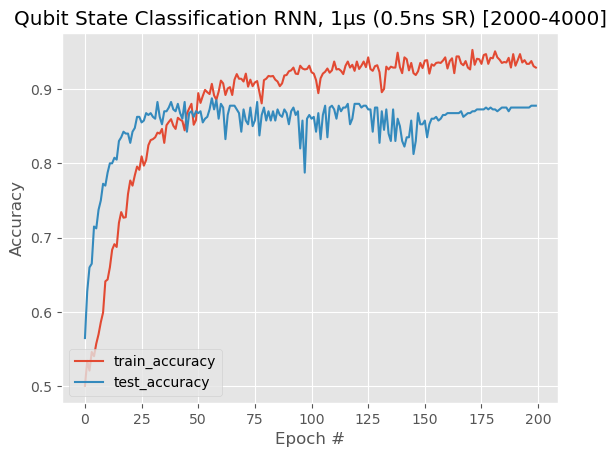

In [19]:
N = 200
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="test_accuracy")
plt.title("Qubit State Classification RNN, 1\u03BCs (0.5ns SR) [2000-4000]")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

# Inference

In [8]:
model=load_model("/home/neel/Berkely_Quantum/Model/RNN_new/57-0.8875.h5", compile=False)
p,g=[],[]
for j,i in enumerate(X_test):
    i=np.expand_dims(i,axis=0)
    pred=model.predict(i)
    print("Ground Truth:- ",yTest[j],"\nPrediction:- ",pred,)
    p.append(float(pred))
    g.append(yTest[j])


2023-07-31 18:15:44.645567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 18:15:45.388500: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46113 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:19:00.0, compute capability: 8.6


1/1 [==============================] - 2s 2s/step


2023-07-31 18:15:48.008947: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-07-31 18:15:48.145313: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Ground Truth:-  1.0 
Prediction:-  [[0.9551433]]
1/1 [==============================] - 0s 25ms/step
Ground Truth:-  0.0 
Prediction:-  [[0.01979821]]
1/1 [==============================] - 0s 19ms/step
Ground Truth:-  1.0 
Prediction:-  [[0.9377222]]
1/1 [==============================] - 0s 20ms/step
Ground Truth:-  0.0 
Prediction:-  [[0.02875638]]
1/1 [==============================] - 0s 22ms/step
Ground Truth:-  1.0 
Prediction:-  [[0.9092535]]
1/1 [==============================] - 0s 18ms/step
Ground Truth:-  1.0 
Prediction:-  [[0.9015065]]
1/1 [==============================] - 0s 18ms/step
Ground Truth:-  0.0 
Prediction:-  [[0.00874278]]
1/1 [==============================] - 0s 18ms/step
Ground Truth:-  1.0 
Prediction:-  [[0.94515115]]
1/1 [==============================] - 0s 19ms/step
Ground Truth:-  0.0 
Prediction:-  [[0.00821144]]
1/1 [==============================] - 0s 18ms/step
Ground Truth:-  1.0 
Prediction:-  [[0.9487119]]
1/1 [==============================] 

In [ ]:
t=0
for i in range(len(p)):
    if (p[i]<0.5 and g[i]==0) or (p[i]>=0.5 and g[i]==1):
        t+=1
print((t*100)/len(p))

In [ ]:
print(f1_score(p,g))

# Quantization and HLS4ML

In [45]:
from hls4ml.model import profiling
config = hls4ml.utils.config_from_keras_model(model, granularity='Model')
config['Model']['Precision']='ap_fixed<8,2>'
print("-----------------------------------")
print("Configuration")
print("-----------------------------------")
hls_model_std = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_2/hls4ml_prj', part='xczu49dr-2ffvf1760'
)

Interpreting Sequential
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 10, 10]], output shape: [None, 10, 10]
Layer name: lstm, layer type: LSTM, input shapes: [[None, 10, 10]], output shape: [None, 10, 64]
Layer name: lstm_1, layer type: LSTM, input shapes: [[None, 10, 64]], output shape: [None, 64]
Layer name: dense_5, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: dense_6, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: dense_7, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 16]
Layer name: dense_8, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 4]
Layer name: dense_9, layer type: Dense, input shapes: [[None, 4]], output shape: [None, 1]
-----------------------------------
Configuration
-----------------------------------
Interpreting Sequential
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 10, 10]], output sh

In [33]:
hls4ml.utils.plot_model(hls_model_std, show_shapes=True, show_precision=True, to_file=None)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [46]:
hls_model_std.compile()
y_hls_std=hls_model_std.predict(np.ascontiguousarray(X_test))

Writing HLS project
Done


In [37]:
y_keras = model.predict(X_test)

13/13 [==============================] - 0s 3ms/step


In [47]:
hls_model_std.build()

Exception: Vivado HLS installation not found. Make sure "vivado_hls" is on PATH.